In [69]:
%matplotlib notebook

In [70]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.optimize #https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve%5Ffit.html
from mpl_toolkits.mplot3d import Axes3D

Bragg's Law: $d = \frac{n\lambda}{2\sin\theta}$

In [71]:
lam = 1.5406e-10 #wavelength for Cu K-alpha radiation
n = 1 #quantum integer

def calc_d(peak_loc):
    theta = math.radians(peak_loc / 2)
    d = n*lam / (2* math.sin(theta)) #d spacing (m)
    return d 

def calc_d_sigma(peak_loc, peak_loc_sigma):
    theta = math.radians(peak_loc / 2)
    theta_sigma = math.radians(peak_loc_sigma / 2)
    d = n*lam / (2* math.sin(theta)) #d spacing (m)
    d_sigma = (n * lam / 2) * (math.cos(theta) / math.sin(theta)**2) * theta_sigma
    return d_sigma

# 1 independent unit cell parameter

In [74]:
#1 unit cell length
def linear(independent_var, a, b):
    return a * independent_var + b

***

## Cubic
$a = b = c$

$\alpha = \beta = \gamma = 90° $ 

$ \frac{1}{d_{hkl}^2} = \frac{h^2 + k^2 +l^2}{a^2}$

In [75]:
#sample data (Pt, Pearson's 9141341)
peak_list = ['111','200','220','311','222'] #indices of observed peaks
loc_list = [39.78, 46.26, 67.50, 81.32, 85.76] #observed position of peaks
sigma_list = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2] #uncertainty on observed position of peaks
data = {'Peak': peak_list, 'Location': loc_list, 'LocSigma': sigma_list}
cubic_pattern = pd.DataFrame(data)

In [76]:
cubic_pattern

,Peak,Location,LocSigma
0,111,39.78,0.01
1,200,46.26,0.01
2,220,67.50,0.01
3,311,81.32,0.01
4,222,85.76,0.01


In [77]:
r = [] #response variable (1/d^2)
r_sigma = [] #error on 1/d^2
x = [] #sqrt(h^2 + k^2 + l^2) (exact, no error)

index_list = ['origin']
x.append(0) #limit as h,k,l go to 0
r.append(0) #limit as 1/d^2 goes to 0
r_sigma.append(1e-10) #approximately 0 error on origin (exactly 0 will cause an error)

for index, row in cubic_pattern.iterrows():
    h = int(row['Peak'][0])
    k = int(row['Peak'][1])
    l = int(row['Peak'][2])
    index_list.append(row['Peak'])
    x.append(h**2 + k**2 + l**2)
    r.append(1/calc_d(row['Location'])**2)
    r_sigma.append(calc_d_sigma(row['Location'],row['LocSigma'])*(2/calc_d(row['Location'])**3))
        
fit, cov = scipy.optimize.curve_fit(linear, x, r, sigma = r_sigma, p0 = [1e19, 1.])
err = np.sqrt(np.diag(cov))

calc_a = (1/math.sqrt(fit[0])) #meters
calc_a_sigma = calc_a * (err[0] / fit[0])

calc_V = calc_a**3 #cubic meters
calc_V_sigma = ((calc_a_sigma / calc_a)*3) * calc_V

print('Volume:', round(calc_V*1e30,4), '±', round(calc_V_sigma*1e30,4), 'cubic Å')
print('\ta:', round(calc_a*1e10,4), '±', round(calc_a_sigma*1e10,4), 'Å')

Volume: 60.2999 ± 0.0134 cubic Å
	a: 3.9214 ± 0.0003 Å


<IPython.core.display.Javascript object>


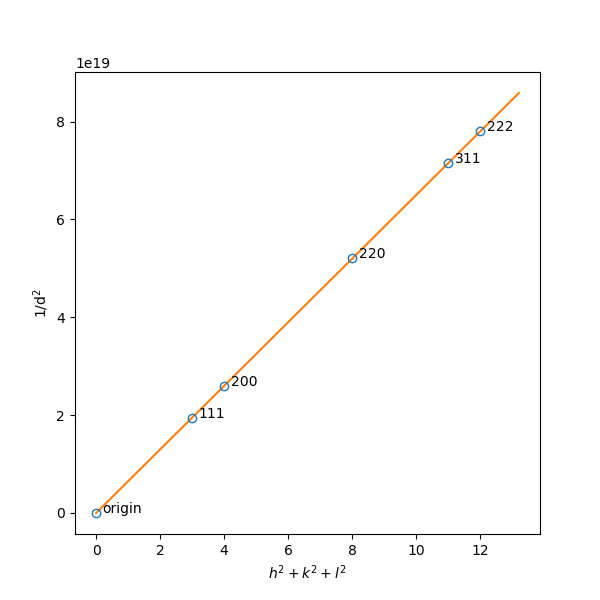

In [78]:
#check that points are colinear

x_range = np.linspace(0,max(x)*1.1,10)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.errorbar(x, r, yerr = r_sigma, marker = 'o', elinewidth = 1, mfc = 'none', ecolor = 'k', linestyle = 'none')
ax.plot(x_range, (x_range * fit[0] + fit[1]))
for i, txt in enumerate(index_list):
    ax.text(x[i]+0.2, r[i], txt)

ax.set_xlabel('$h^2+k^2+l^2$')
ax.set_ylabel('1/d$^2$')
plt.show()

***

# 2 independent unit cell parameters

In [79]:
#2 unit cell lengths or 1 unit cell length + 1 unit cell angle
def planar(independent_vars, a, b, c):
    var1,var2 = independent_vars
    return a * var1 + b * var2 + c

***

## Tetragonal
$a = b$

$\alpha = \beta = \gamma = 90° $ 

$ \frac{1}{d_{hkl}^2} = \frac{h^2 + k^2}{a^2} + \frac{l^2}{c^2}$

In [103]:
#sample data (Ge, Pearson's 1412394)
peak_list = ['101', '002', '110', '112', '200', '103', '211'] #indices of observed peaks
loc_list = [32.92,36.34,39.10,54.44,56.48,63.24,66.94] #observed position of peaks
sigma_list = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2] #uncertainty on observed position of peaks
data = {'Peak': peak_list, 'Location': loc_list, 'LocSigma': sigma_list}
tetragonal_pattern = pd.DataFrame(data)

In [104]:
tetragonal_pattern

,Peak,Location,LocSigma
0,101,32.92,0.01
1,002,36.34,0.01
2,110,39.10,0.01
3,112,54.44,0.01
4,200,56.48,0.01
5,103,63.24,0.01
6,211,66.94,0.01


In [105]:
r = [] #response variable (1/d^2)
r_sigma = [] #error on 1/d^2
x = [] #h^2 + k^2
y = [] #l^2

index_list = ['origin']
r.append(0) #limit as 1/d^2 goes to 0
r_sigma.append(1e-10) #approximately 0 error on origin (exactly 0 will cause an error)
x.append(0) #limit as h,k go to 0
y.append(0) #limit as l goes to 0

for index, row in tetragonal_pattern.iterrows():
        h = int(row['Peak'][0])
        k = int(row['Peak'][1])
        l = int(row['Peak'][2])
        index_list.append(row['Peak'])
        x.append(h**2 + k**2)
        y.append(l**2)
        r.append(1/calc_d(row['Location'])**2)
        r_sigma.append(1/calc_d_sigma(row['Location'],row['LocSigma']))
    
fit, cov = scipy.optimize.curve_fit(planar, [x,y], r, sigma = r_sigma, p0 = [1e19, 1e19, 1.])
err = np.sqrt(np.diag(cov))

calc_a = (1/math.sqrt(fit[0])) #m
calc_a_sigma = calc_a * (err[0] / fit[0])
calc_c = (1/math.sqrt(fit[1])) #m
calc_c_sigma = calc_c * (err[1] / fit[1])

calc_V = calc_a**2 * calc_c
calc_V_sigma = ((calc_a_sigma / calc_a)*2 +  (calc_c_sigma / calc_c)) * calc_V

print('Volume:', round(calc_V*1e30,4), '±', round(calc_V_sigma*1e30,4), 'cubic Å')
print('\ta:', round(calc_a*1e10,4), '±', round(calc_a_sigma*1e10,4), 'Å')
print('\tc:', round(calc_c*1e10,4), '±', round(calc_c_sigma*1e10,4), 'Å')

Volume: 52.3646 ± 0.0172 cubic Å
	a: 3.2558 ± 0.0003 Å
	c: 4.94 ± 0.0007 Å


<IPython.core.display.Javascript object>


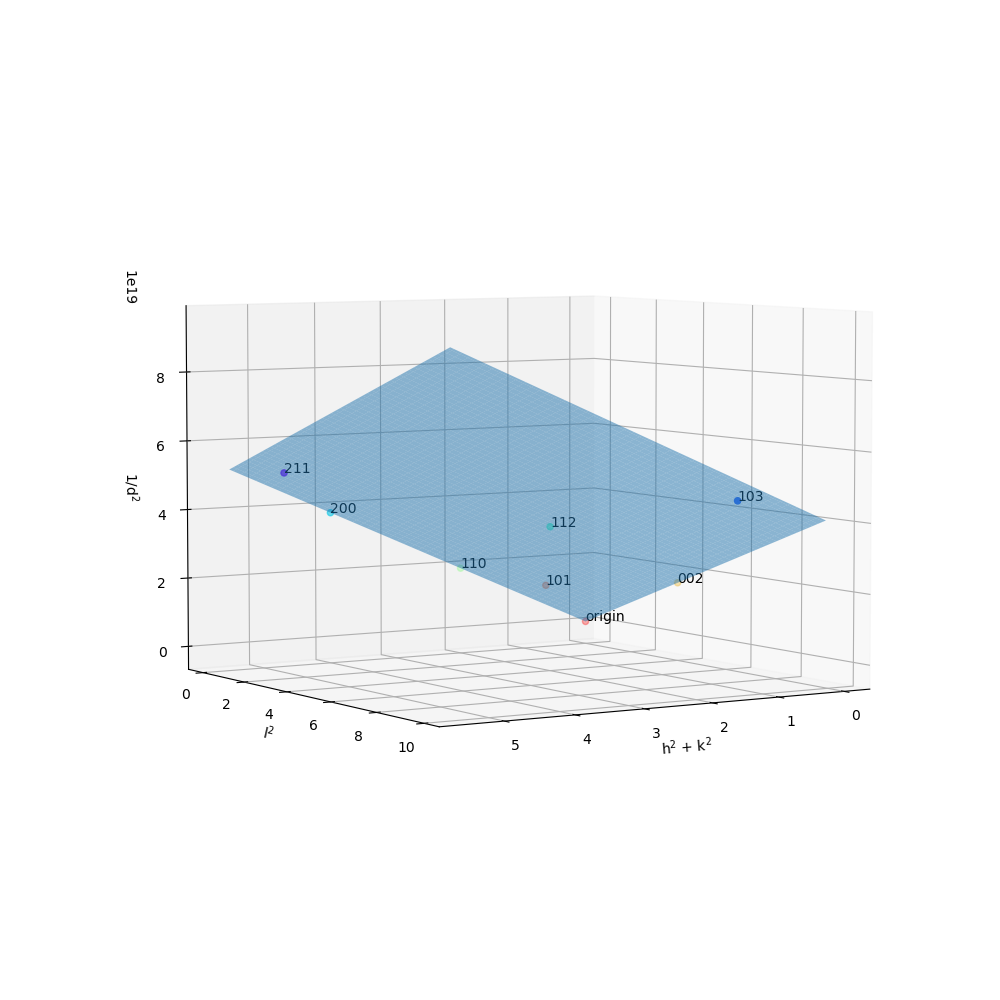

In [106]:
#check that points are coplanar

x_range = np.linspace(0,max(x)*1.1,100)
y_range = np.linspace(0,max(y)*1.1,100)
x_mesh, y_mesh = np.meshgrid(x_range, y_range)
eq = planar([x_mesh,y_mesh],fit[0],fit[1],fit[2]) #calculate r over x, y range

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(x_mesh, y_mesh, eq, alpha = 0.5)

ax.view_init(10,50)
ax.set_xlabel('h$^2$ + k$^2$')
ax.set_ylabel('l$^2$')
ax.set_zlabel('1/d$^2$')


rainbow_reverse = cmap_reversed = plt.cm.get_cmap('rainbow_r') #colors red to purple in rgbiv order
colors = rainbow_reverse(np.linspace(0, 1, len(x)))

ax.scatter(x,y,r, c = colors)
for i, txt in enumerate(index_list):
    ax.text(x[i], y[i], r[i], txt)
    
plt.show()

***

## Hexagonal
$a = b $

$\alpha = \beta = 90°, ~\gamma = 120° $ 

$ \frac{1}{d_{hkl}^2} = \frac{4}{3} \left(\frac{h^2 ~+~ hk ~+~ k^2}{a^2}\right) + \frac{l^2}{c^2}$

In [107]:
#sample data (Cd, Pearson's 1212322)
peak_list = ['002', '100', '101', '102', '103', '110', '004', '112'] #indices of observed peaks
loc_list = [32.54, 34.86, 38.62, 48.42, 62.12, 62.5, 68.14, 72.24] #observed position of peaks
sigma_list = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2] #uncertainty on observed position of peaks
data = {'Peak': peak_list, 'Location': loc_list, 'LocSigma': sigma_list}
hexagonal_pattern = pd.DataFrame(data)

In [108]:
hexagonal_pattern

,Peak,Location,LocSigma
0,002,32.54,0.01
1,100,34.86,0.01
2,101,38.62,0.01
3,102,48.42,0.01
4,103,62.12,0.01
5,110,62.50,0.01
6,004,68.14,0.01
7,112,72.24,0.01


In [109]:
r = [] #response variable (1/d^2)
r_sigma = [] #error on 1/d^2
x = [] #(4/3)(h^2 + hk+ k^2)
y = [] #l^2

index_list = ['origin']
r.append(0) #limit as 1/d^2 goes to 0
r_sigma.append(1e-10) #approximately 0 error on origin (exactly 0 will cause an error)
x.append(0) #limit as (4/3)(h^2 + hk+ k^2) go to 0
y.append(0) #limit as l goes to 0

for index, row in hexagonal_pattern.iterrows():
        h = int(row['Peak'][0])
        k = int(row['Peak'][1])
        l = int(row['Peak'][2])
        index_list.append(row['Peak'])
        x.append((4/3)*(h**2 + h*k + k**2))
        y.append(l**2)
        r.append(1/calc_d(row['Location'])**2)
        r_sigma.append(1/calc_d_sigma(row['Location'],row['LocSigma']))
    
fit, cov = scipy.optimize.curve_fit(planar, [x,y], r, sigma = r_sigma, p0 = [1e19, 1e19, 1.])
err = np.sqrt(np.diag(cov))

calc_a = (1/math.sqrt(fit[0])) #m
calc_a_sigma = calc_a * (err[0] / fit[0])
calc_c = (1/math.sqrt(fit[1])) #m
calc_c_sigma = calc_c * (err[1] / fit[1])

calc_V = calc_a**2 * calc_c * math.sqrt(3) / 2
calc_V_sigma = ((calc_a_sigma / calc_a)*2 +  (calc_c_sigma / calc_c)) * calc_V

#note that the hexagonal unit cell is a rhombic prism (i.e., 1/3 of the hexagonal prism)
print('Volume:', round(calc_V*1e30,4), '±', round(calc_V_sigma*1e30,4), 'cubic Å')
print('\ta:', round(calc_a*1e10,4), '±', round(calc_a_sigma*1e10,4), 'Å')
print('\tc:', round(calc_c*1e10,4), '±', round(calc_c_sigma*1e10,4), 'Å')

Volume: 42.0038 ± 0.0174 cubic Å
	a: 2.9697 ± 0.0004 Å
	c: 5.4997 ± 0.0008 Å


<IPython.core.display.Javascript object>


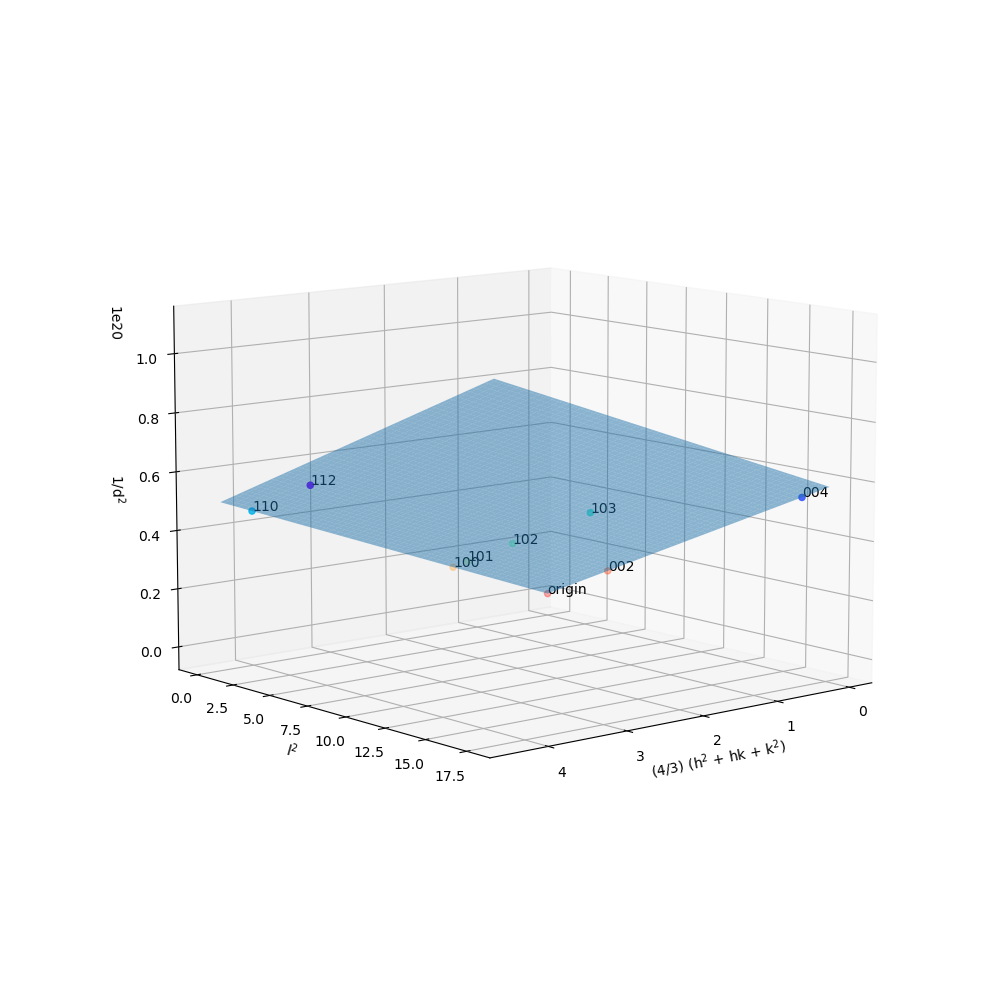

In [110]:
#check that points are coplanar

x_range = np.linspace(0,max(x)*1.1,100)
y_range = np.linspace(0,max(y)*1.1,100)
x_mesh, y_mesh = np.meshgrid(x_range, y_range)

eq = planar([x_mesh,y_mesh],fit[0],fit[1],fit[2]) #calculate r over x, y range

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(x_mesh, y_mesh, eq, alpha = 0.5)

ax.view_init(10,50)
ax.set_xlabel('(4/3) (h$^2$ + hk + k$^2$)')
ax.set_ylabel('l$^2$')
ax.set_zlabel('1/d$^2$')


rainbow_reverse = cmap_reversed = plt.cm.get_cmap('rainbow_r') #colors red to purple in rgbiv order
colors = rainbow_reverse(np.linspace(0, 1, len(x)))

ax.scatter(x,y,r, c = colors)
for i, txt in enumerate(index_list):
    ax.text(x[i], y[i], r[i], txt)
    
plt.show()

***

<div class="alert alert-block alert-warning">
Below this point, the remaining lattice systems either have too many dimensions to show graphically, or the unit cell parameters are not linearly independent, or both.
</div>

***

## Rhombohedral
$a = b = c$

$\alpha = \beta = \gamma $ 


$ \frac{1}{d_{hkl}^2} = \frac{(h^2 ~+~ k^2 ~+~ l^2) \sin^{2}\alpha~+~2(hk~+~kl~+~lh)(\cos^{2}\alpha ~-~ \cos\alpha)}{a^2(1 +~ 2 \cos^{3}\alpha ~-~ 3 \cos^{2}\alpha)}$

<div class="alert alert-block alert-info">

<b>Note:</b> Structures in the rhombohedral lattice system are often indexed with hexagonal unit cells ($a = b$, $\alpha = \beta = 90 °$, $\gamma = 120°$). If you want to determine the rhombohedral unit cell parameters, the reflections must be indexed with rhombohedral $h$,$k$,$l$.
</div>

In [88]:
def rhombohedral_condition(independent_vars, a, alpha_degrees):
    h = independent_vars[0]
    k = independent_vars[1]
    l = independent_vars[2] 
    alpha = math.radians(alpha_degrees)
    numerator = (h**2 + k**2 + l**2) * math.sin(alpha)**2 + 2 * (h*k + k*l + l*h) * (math.cos(alpha)**2 - math.cos(alpha))
    denominator = (a**2)  * (1 + 2 * math.cos(alpha)**3 - 3 * math.cos(alpha)**2)
    return numerator/denominator

In [89]:
#sample data (Cr[CN]3[NH3]3, Pearson's 1614321)
peak_list = [[1,0,-1],'110','200',[2,1,-1],[3,0,-1],[2,2,-2],'310','130',[1,2,-3],[3,1,-2],[3,2,-1]] #this is how to use negative or double-digit indicies
loc_list = [15.74,18.48,24.36,29.14,37.02,40.45,40.86,40.86,42.48,43.66,47.05]
sigma_list = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3,1e-3]
data = {'Peak': peak_list, 'Location': loc_list, 'LocSigma': sigma_list}
rhombohedral_pattern = pd.DataFrame(data)

In [90]:
rhombohedral_pattern

,Peak,Location,LocSigma
0,"[1, 0, -1]",15.74,0.001
1,110,18.48,0.001
2,200,24.36,0.001
3,"[2, 1, -1]",29.14,0.001
4,"[3, 0, -1]",37.02,0.001
5,"[2, 2, -2]",40.45,0.001
6,310,40.86,0.001
7,130,40.86,0.001
8,"[1, 2, -3]",42.48,0.001
9,"[3, 1, -2]",43.66,0.001


In [91]:
r = [] #response variable (1/d^2)
r_sigma = [] #error on 1/d^2
x = []  #h
y = []  #k
z = []  #l

#origin
r.append(0) #limit as 1/d^2 goes to 0
r_sigma.append(1e-10) #approximately 0 error on origin (exactly 0 will cause an error)
x.append(0) 
y.append(0)
z.append(0)

for index, row in rhombohedral_pattern.iterrows():
        h = int(row['Peak'][0])
        k = int(row['Peak'][1])
        l = int(row['Peak'][2])
        x.append(h)
        y.append(k)
        z.append(l)
        r.append(1/calc_d(row['Location'])**2)
        r_sigma.append(1/calc_d_sigma(row['Location'],row['LocSigma']))

fit, cov = scipy.optimize.curve_fit(rhombohedral_condition, [x,y,z], r, sigma = r_sigma, p0 = [1e-10,90.])
err = np.sqrt(np.diag(cov))

calc_a = fit[0] #m
calc_a_sigma = err[0]
calc_alpha = fit[1] #degrees
calc_alpha_sigma = err[1]
calc_V = calc_a**3 * math.sqrt(1 - 3*math.cos(math.radians(calc_alpha))**2 + 2*math.cos(math.radians(calc_alpha))**3)
calc_V_sigma = calc_a_sigma * 3 * calc_a**2 * math.sqrt(1 - 3*math.cos(math.radians(calc_alpha))**2 + 2*math.cos(math.radians(calc_alpha))**3)+ calc_alpha_sigma * 3 * calc_a_sigma**3 * math.sin(math.radians(calc_alpha)) * (math.cos(math.radians(calc_alpha)) - math.cos(math.radians(calc_alpha)**2))/math.sqrt(1 + 2 * math.cos(math.radians(calc_alpha))**3 - 3 * math.cos(math.radians(calc_alpha))**2)

print('Volume:', round(calc_V*1e30,4), '±', round(calc_V_sigma*1e30,4), 'cubic Å')
print('\ta:', round(calc_a*1e10,4), '±', round(calc_a_sigma*1e10,4), 'Å')
print('\talpha:', round(calc_alpha,4), '±', round(calc_alpha_sigma,4), 'degrees')

Volume: 402.8945 ± 0.0301 cubic Å
	a: 7.4634 ± 0.0002 Å
	alpha: 97.8345 ± 0.0029 degrees


***

# >2 independent unit cell parameters

***

## Othorhombic

$\alpha = \beta = \gamma = 90° $ 


$ \frac{1}{d_{hkl}^2} = \frac{h^2}{a^2} + \frac{k^2}{b^2} + \frac{l^2}{c^2}$

In [92]:
#three unit cell lengths
def three_vars(independent_vars, a, b, c, d):
    var1,var2,var3 = independent_vars
    return a * var1 + b * var2 + c * var3 + d

In [114]:
#sample data (FeTiO3, Pearson's 1238178)
peak_list = ['111', '200', '121', '002', '202', '212', '311', '123'] #indices of observed peaks
loc_list = [27.60, 34.10, 35.08, 36.14, 50.42, 52.20, 57.16, 64.30] #observed position of peaks
sigma_list = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2] #uncertainty on observed position of peaks
data = {'Peak': peak_list, 'Location': loc_list, 'LocSigma': sigma_list}
orthorhombic_pattern = pd.DataFrame(data)

In [112]:
orthorhombic_pattern

,Peak,Location,LocSigma
0,111,27.60,0.01
1,200,34.10,0.01
2,121,35.08,0.01
3,002,36.14,0.01
4,202,50.42,0.01
5,212,52.20,0.01
6,311,57.16,0.01
7,123,64.30,0.01


In [113]:
r = [] #response variable (1/d^2)
r_sigma = [] #error on 1/d^2
x = [] #h^2
y = [] #k^2
z = [] #l^2

index_list = ['origin']
r.append(0) #limit as 1/d^2 goes to 0
r_sigma.append(1e-10) #approximately 0 error on origin (exactly 0 will cause an error)
x.append(0) #limit as h go to 0
y.append(0) #limit as k goes to 0
z.append(0) #limit as l goes to 0

for index, row in orthorhombic_pattern.iterrows():
        h = int(row['Peak'][0])
        k = int(row['Peak'][1])
        l = int(row['Peak'][2])
        index_list.append(row['Peak'])
        x.append(h**2)
        y.append(k**2)
        z.append(l**2)
        r.append(1/calc_d(row['Location'])**2)
        r_sigma.append(1/calc_d_sigma(row['Location'],row['LocSigma']))
    
fit, cov = scipy.optimize.curve_fit(three_vars, [x,y,z], r, sigma = r_sigma, p0 = [1e19, 1e19, 1e19, 1.])
err = np.sqrt(np.diag(cov))

calc_a = (1/math.sqrt(fit[0])) #m
calc_a_sigma = calc_a * (err[0] / fit[0])
calc_b = (1/math.sqrt(fit[1])) #m
calc_b_sigma = calc_a * (err[1] / fit[1])
calc_c = (1/math.sqrt(fit[2])) #m
calc_c_sigma = calc_c * (err[2] / fit[2])

calc_V = calc_a* calc_b * calc_c
calc_V_sigma = ((calc_a_sigma / calc_a) +  (calc_b_sigma / calc_b) + (calc_c_sigma / calc_c)) * calc_V

print('Volume:', round(calc_V*1e30,4), '±', round(calc_V_sigma*1e30,4), 'cubic Å')
print('\ta:', round(calc_a*1e10,4), '±', round(calc_a_sigma*1e10,4), 'Å')
print('\tb:', round(calc_b*1e10,4), '±', round(calc_b_sigma*1e10,4), 'Å')
print('\tc:', round(calc_c*1e10,4), '±', round(calc_c_sigma*1e10,4), 'Å')

Volume: 188.911 ± 0.9259 cubic Å
	a: 5.2556 ± 0.0064 Å
	b: 7.2336 ± 0.0174 Å
	c: 4.9691 ± 0.0063 Å


***

## Monoclinic

$\alpha = \gamma = 90° $ 


$ \frac{1}{d_{hkl}^2} = \frac{1}{\sin^{2}\beta} \left(\frac{h^2}{a^2} + \frac{k^2 \sin^{2}\beta}{b^2} + \frac{l^2}{c^2} - \frac{2hl \cos \beta}{ac} \right)$

In [96]:
#three unit cell lengths and one unit cell angle
def monoclinic_condition(independent_vars,a,b,c,beta_degrees):
    h = independent_vars[0]
    k = independent_vars[1]
    l = independent_vars[2]
    beta = math.radians(beta_degrees)
    term1 = h**2/a**2
    term2 = k**2 * math.sin(beta)**2 / b**2
    term3 = l**2/c**2
    term4 = 2 * h * l * math.cos(beta) / (a * c)
    return (1/math.sin(beta)**2) * (term1 + term2 + term3 - term4)

In [122]:
#sample data (FeWO4, Pearson's 1831870)
peak_list = ['010','100','011','110',[1,1,-1],'111','020','002','021','130']
loc_list = [15.54, 18.94, 23.70, 24.60, 30.50, 30.54, 31.38, 36.02, 36.3, 51.92]
sigma_list = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
data = {'Peak': peak_list, 'Location': loc_list, 'LocSigma': sigma_list}
monoclinic_pattern = pd.DataFrame(data)

In [123]:
r = [] #response variable (1/d^2)
r_sigma = [] #error on 1/d^2
x = [] #h
y = [] #k
z = [] #l

#origin
r.append(0) #limit as 1/d^2 goes to 0
r_sigma.append(1e-10) #approximately 0 error on origin (exactly 0 will cause an error)
x.append(0) #limit as h go to 0
y.append(0) #limit as k goes to 0
z.append(0) #limit as l goes to 0

for index, row in monoclinic_pattern.iterrows():
        h = int(row['Peak'][0])
        k = int(row['Peak'][1])
        l = int(row['Peak'][2])
        x.append(h)
        y.append(k)
        z.append(l)
        r.append(1/calc_d(row['Location'])**2)
        r_sigma.append(1/calc_d_sigma(row['Location'],row['LocSigma']))
    
fit, cov = scipy.optimize.curve_fit(monoclinic_condition, [x,y,z], r, sigma = r_sigma, p0 = [1e-9, 1e-9, 1e-9, 90.])
err = np.sqrt(np.diag(cov))

calc_a = fit[0] #m
calc_a_sigma = err[0]
calc_b = fit[1] #m
calc_b_sigma = err[1]
calc_c = fit[2] #m
calc_c_sigma = err[2]
calc_beta = fit[3] #degrees
calc_beta_sigma = err[3]

calc_V = calc_a* calc_b * calc_c * math.sin(math.radians(calc_beta))
calc_V_sigma = ((calc_a_sigma / calc_a) +  (calc_b_sigma / calc_b) + (calc_c_sigma / calc_c) + calc_beta_sigma * math.cos(math.radians(calc_beta))) * calc_V

print('Volume:', round(calc_V*1e30,4), '±', round(calc_V_sigma*1e30,4), 'cubic Å')
print('\ta:', round(calc_a*1e10,4), '±', round(calc_a_sigma*1e10,4), 'Å')
print('\tb:', round(calc_b*1e10,4), '±', round(calc_b_sigma*1e10,4), 'Å')
print('\tc:', round(calc_c*1e10,4), '±', round(calc_c_sigma*1e10,4), 'Å')
print('\tbeta:', round(calc_beta,4), '±', round(calc_beta_sigma,4), 'degrees')

Volume: 132.8775 ± 0.0362 cubic Å
	a: 4.6809 ± 0.0005 Å
	b: 5.697 ± 0.0004 Å
	c: 4.9829 ± 0.0006 Å
	beta: 90.0998 ± 0.0153 degrees


***

## Triclinic
$ \frac{1}{d_{hkl}^2} = \frac{1}{1~ +~ 2 \cos\alpha\cos\beta\cos\gamma ~-~ \cos^{2}\alpha ~-~ \cos^{2}\beta ~-~ \cos^{2}\gamma} \times \left\{ \frac{h^2 \sin^2\alpha}{a^2} + \frac{k^2 \sin^2\beta}{b^2} + \frac{l^2 \sin^2\gamma}{c^2} + \frac{2hk}{ab} (\cos\alpha\cos\beta ~-~ \cos\gamma) ~+~ \frac{2kl}{bc} (\cos\beta\cos\gamma ~-~ \cos\alpha) ~+~ \frac{2lh}{ac} (\cos\gamma\cos\alpha ~-~ \cos\beta) \right\} $

<div class="alert alert-block alert-info">

<b>Note:</b> The formula for the lattice spacing of a unit cell with triclinc geometry ($a \neq b \neq c, \alpha \neq \beta \neq \gamma$) is also the general formula that applies to all crystals. However, failing to include geometric constraints if the crystal is not truly triclinc will probably result in a bad refinement.
</div>

In [99]:
#three unit cell lengths and three unit cell angles
def triclinic_condition(independent_vars,a,b,c,alpha_degrees,beta_degrees,gamma_degrees):
    h = independent_vars[0]
    k = independent_vars[1]
    l = independent_vars[2]
    alpha = math.radians(alpha_degrees)
    beta = math.radians(beta_degrees)
    gamma = math.radians(gamma_degrees)
    term1 = 1/(1 + 2*math.cos(alpha)*math.cos(beta)*math.cos(gamma) - math.cos(alpha)**2 - math.cos(beta)**2 - math.cos(gamma)**2)
    term2 = h**2 * math.sin(alpha)**2 / a**2
    term3 = k**2 * math.sin(beta)**2 / b**2
    term4 = l**2 * math.sin(gamma)**2 / c**2
    term5 = (2*h*k/(a*b)) * (math.cos(alpha)*math.cos(beta) - math.cos(gamma))
    term6 = (2*k*l/(b*c)) * (math.cos(beta)*math.cos(gamma) - math.cos(alpha))
    term7 = (2*l*h/(a*c)) * (math.cos(gamma)*math.cos(alpha) - math.cos(beta))
    return term1 * (term2+term3+term4+term5+term6+term7)

In [100]:
#sample data (Bi, Pearson's 1532472)
peak_list = ['001','010','101',['1','0','-1'],'112',['1','-1','0'],'121','211','222','132']
loc_list = [22.00,23.52,26.84,37.40,37.48,39.32,39.32,39.36,48.4,64.1]
sigma_list = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3]
data = {'Peak': peak_list, 'Location': loc_list, 'LocSigma': sigma_list}
triclinic_pattern = pd.DataFrame(data)

In [101]:
triclinic_pattern

,Peak,Location,LocSigma
0,001,22.00,0.001
1,010,23.52,0.001
2,101,26.84,0.001
3,"[1, 0, -1]",37.40,0.001
4,112,37.48,0.001
5,"[1, -1, 0]",39.32,0.001
6,121,39.32,0.001
7,211,39.36,0.001
8,222,48.40,0.001
9,132,64.10,0.001


In [102]:
r = [] #response variable (1/d^2)
r_sigma = [] #error on 1/d^2
x = []  #h
y = []  #k
z = []  #l

#origin
r.append(0) #limit as 1/d^2 goes to 0
r_sigma.append(1e-10) #approximately 0 error on origin (exactly 0 will cause an error)
x.append(0) 
y.append(0)
z.append(0)

for index, row in triclinic_pattern.iterrows():
        h = int(row['Peak'][0])
        k = int(row['Peak'][1])
        l = int(row['Peak'][2])
        x.append(h)
        y.append(k)
        z.append(l)
        r.append(1/calc_d(row['Location'])**2)
        r_sigma.append(1/calc_d_sigma(row['Location'],row['LocSigma']))

fit, cov = scipy.optimize.curve_fit(triclinic_condition, [x,y,z], r, sigma = r_sigma, p0 = [1e-10,1e-10,1e-10,90.,90.,90.])
err = np.sqrt(np.diag(cov))

calc_a = fit[0] #m
calc_a_sigma = err[0]
calc_b = fit[1] #m
calc_b_sigma = err[1]
calc_c = fit[2] #m
calc_c_sigma = err[2]
calc_alpha = fit[3] #degrees
calc_alpha_sigma = err[3]
calc_beta = fit[4] #degrees
calc_beta_sigma = err[4]
calc_gamma = fit[5] #degrees
calc_gamma_sigma = err[5]

g = math.sqrt(1 + 2*math.cos(math.radians(calc_alpha))*math.cos(math.radians(calc_beta))*math.cos(math.radians(calc_gamma))
                - math.cos(math.radians(calc_alpha))**2 - math.cos(math.radians(calc_beta))**2 - math.cos(math.radians(calc_gamma))**2)
g_sigma = calc_alpha_sigma * math.sin(math.radians(calc_alpha)) * (math.cos(math.radians(calc_alpha)) - math.cos(math.radians(calc_gamma)) * math.cos(math.radians(calc_beta))) / g 
+ calc_beta_sigma * math.sin(math.radians(calc_beta)) * (math.cos(math.radians(calc_beta)) - math.cos(math.radians(calc_gamma)) * math.cos(math.radians(calc_alpha))) / g
+ calc_gamma_sigma * math.sin(math.radians(calc_gamma)) * (math.cos(math.radians(calc_gamma)) - math.cos(math.radians(calc_alpha)) * math.cos(math.radians(calc_beta))) / g
calc_V = calc_a * calc_b * calc_c * g
calc_V_sigma = calc_a_sigma * calc_b * calc_c * g + calc_b_sigma * calc_a * calc_c * g + calc_c_sigma * calc_a * calc_b * g + g_sigma * calc_b * calc_c * calc_a


print('Volume:', round(calc_V*1e30,4), '±', round(calc_V_sigma*1e30,4), 'cubic Å')
print('\ta:', round(calc_a*1e10,4), '±', round(calc_a_sigma*1e10,4), 'Å')
print('\tb:', round(calc_b*1e10,4), '±', round(calc_b_sigma*1e10,4), 'Å')
print('\tc:', round(calc_c*1e10,4), '±', round(calc_c_sigma*1e10,4), 'Å')
print('\talpha:', round(calc_alpha,4), '±', round(calc_alpha_sigma,4), 'degrees')
print('\tbeta:', round(calc_beta,4), '±', round(calc_beta_sigma,4), 'degrees')
print('\tgamma:', round(calc_gamma,4), '±', round(calc_gamma_sigma,4), 'degrees')

Volume: 73.2403 ± 0.4029 cubic Å
	a: 4.5744 ± 0.0006 Å
	b: 4.5788 ± 0.0005 Å
	c: 4.8089 ± 0.0005 Å
	alpha: 62.1062 ± 0.0134 degrees
	beta: 61.7447 ± 0.0089 degrees
	gamma: 60.0286 ± 0.0104 degrees
